# 캐글의 타이타닉 데이터로 분류 문제 복습하기 

In [527]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Binarizer

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold, cross_val_score,RepeatedStratifiedKFold

from sklearn.metrics import plot_confusion_matrix,confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, roc_auc_score,f1_score, recall_score

In [528]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

**<h3>column명 설명**

survival : prediction 할 class (0 : no 1 : yes)

pclass : ticket class (1 = 1st, 2 = 2nd, 3 = 3rd)

SisSp : of siblings / spouses aboard the Titanic

parch : of parents / children aboard the Titanic

ticket : ticket number

fare : passenger fare 

cabin : cabin number

embarked : port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)



---



**목표** : survival 0 or 1 을 예측해야 하는 classification 

In [529]:
import pandas as pd

df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')
df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [530]:
test_df

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


# EDA & Preprocessing 

비율 :
 0    61.616162
1    38.383838
Name: Survived, dtype: float64


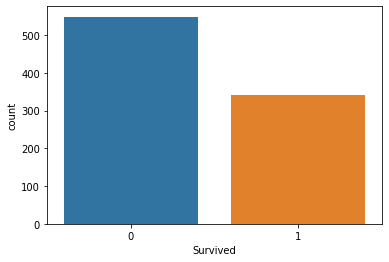

In [531]:
# 타겟 분포 확인 

print('비율 :\n', df['Survived'].value_counts(normalize=True)*100)

sns.countplot(df['Survived']) 


In [532]:
df.isnull().sum()
# missing value 존재 

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [533]:
# correlation 확인 
df.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


In [534]:
df[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)
# 여성일 경우 살아남을 확률이 훨씬 높음 

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [535]:
df[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


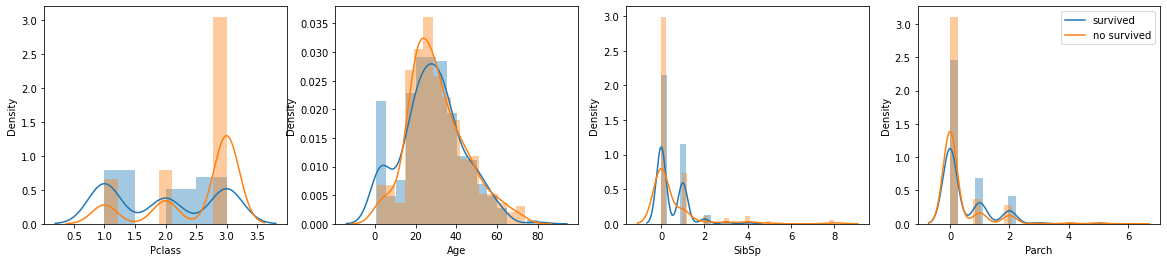

In [536]:
# 수치형 항목들 타겟 분포 그래프 
f, axes = plt.subplots(ncols=4, figsize=(20,4))

sns.distplot(df['Pclass'].loc[df['Survived']==1], ax=axes[0])
sns.distplot(df['Pclass'].loc[df['Survived']==0], ax=axes[0])

sns.distplot(df['Age'].loc[df['Survived']==1], ax=axes[1])
sns.distplot(df['Age'].loc[df['Survived']==0], ax=axes[1])

sns.distplot(df['SibSp'].loc[df['Survived']==1], ax=axes[2])
sns.distplot(df['SibSp'].loc[df['Survived']==0], ax=axes[2])

sns.distplot(df['Parch'].loc[df['Survived']==1], ax=axes[3])
sns.distplot(df['Parch'].loc[df['Survived']==0], ax=axes[3])


plt.legend(['survived','no survived'])

plt.show()
# Pclass 같은 경우 등급에 따라 꽤 차이가 나보임 

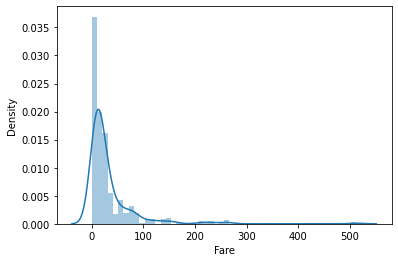

In [537]:
sns.distplot(df['Fare'])
# skewed 됐음 300이상 특이값으로 제거

In [538]:
# 요금은 qcut으로 자르기 
df = df[df['Fare'] <= 300]
df['Fare_grp'] = pd.qcut(df['Fare'], 4)
df[['Fare_grp', 'Survived']].groupby(['Fare_grp'], as_index=False).mean().sort_values(by='Fare_grp', ascending=True)
df = df.drop('Fare_grp', axis=1)

In [539]:
def processing(data):

    # 카테고리컬 데이터 인코딩
    sex_map = {'male':0, 'female':1}
    embark_map = {'C':0, 'Q':1, 'S':2}
    data['sex_enc'] = data['Sex'].replace(sex_map)
    data['embarked_enc'] = data['Embarked'].replace(embark_map)

    
    # 범위로 그룹화 
    data.loc[data['Age'] < 15, 'Age_grp'] = 0
    data.loc[(data['Age'] >= 15) & (data['Age'] < 30), 'Age_grp'] = 1
    data.loc[(data['Age'] >= 30) & (data['Age'] < 45), 'Age_grp'] = 2
    data.loc[(data['Age'] >= 45) & (data['Age'] < 60), 'Age_grp'] = 3
    data.loc[data['Age'] >= 60, 'Age_grp'] = 4

    data.loc[data['Fare'] <= 8.05, 'Fare'] = 0
    data.loc[(data['Fare'] > 8.05) & (data['Fare'] <= 15.5), 'Fare'] = 1
    data.loc[(data['Fare'] > 15.5) & (data['Fare'] <= 32.321), 'Fare'] = 2
    data.loc[data['Fare'] > 32.321, 'Fare'] = 3

    # 부모, 형제 유무로 혼자 탔는지 아닌지 새컬럼 생성 
    data.loc[(data['SibSp'] == 0) | (data['Parch'] == 0), 'isAlone'] = 1
    data.loc[(data['SibSp'] > 0) | (data['Parch'] > 0), 'isAlone'] = 0

    # 필요 없는 열 제거 Cabin 결측치 너무 많아서 제거 
    data.drop(['Name','Cabin','Ticket','Sex', 'Age', 'SibSp', 'Parch', 'Embarked'],axis=1,inplace = True)

    return data 

In [540]:
pd.set_option('mode.chained_assignment',  None)

In [541]:
df = processing(df)
df = df[df['Fare'] <= 300]
df.dropna(inplace=True)
df

,PassengerId,Survived,Pclass,Fare,sex_enc,embarked_enc,Age_grp,isAlone
0,1,0,3,0.0,0,2.0,1.0,0.0
1,2,1,1,3.0,1,0.0,2.0,0.0
2,3,1,3,0.0,1,2.0,1.0,1.0
3,4,1,1,3.0,1,2.0,2.0,0.0
4,5,0,3,0.0,0,2.0,2.0,1.0
...,...,...,...,...,...,...,...,...
885,886,0,3,2.0,1,1.0,2.0,0.0
886,887,0,2,1.0,0,2.0,1.0,1.0
887,888,1,1,2.0,1,2.0,1.0,1.0
889,890,1,1,2.0,0,0.0,1.0,1.0


In [542]:
test_df = processing(test_df)
test_df

,PassengerId,Pclass,Fare,sex_enc,embarked_enc,Age_grp,isAlone
0,892,3,0.0,0,1,2.0,1.0
1,893,3,0.0,1,2,3.0,0.0
2,894,2,1.0,0,1,4.0,1.0
3,895,3,1.0,0,2,1.0,1.0
4,896,3,1.0,1,2,1.0,0.0
...,...,...,...,...,...,...,...
413,1305,3,0.0,0,2,NaN,1.0
414,1306,1,3.0,1,0,2.0,1.0
415,1307,3,0.0,0,2,2.0,1.0
416,1308,3,0.0,0,2,NaN,1.0


<h3>Preprocessing 단계에서 한 것 정리

- 필요 없는 열, null 값 제거 

- age, fare : 범위로 그룹화, fare는 특이치 제거

- sex, embarked : 카테고리컬 데이터 정수화

- 부모, 형제 유무로 혼자 탔는지 아닌지 새컬럼 생성(isAlone)


어느정도 정리 됐으니 이제 본격적으로 training 으로 넘어가보자 

# Training 

In [543]:
y = df['Survived']
X = df.drop(['PassengerId','Survived'], axis=1)
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, random_state=2)
X_test = test_df.drop(['PassengerId'], axis=1)

X_train.shape, X_val.shape, X_test.shape

((567, 6), (142, 6), (418, 6))

In [544]:
# 여러 모델을 돌리기 위해 모델링 함수화 
def modeling(model, X_train, X_test, y_train, y_test):
    
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    print('train cv mean :', (cross_val_score(model, X_train, y_train, cv=5).mean()))
    print('val cv mean : ',(cross_val_score(model, X_test, y_test, cv=5).mean()))
    print('train acc : ', accuracy_score(y_train,model.predict(X_train)))
    print('val acc : ', accuracy_score(y_test,pred))
    # print('\n',classification_report(y_test, pred)) # 스코어 
    return round(accuracy_score(y_train,model.predict(X_train)), 3), round(accuracy_score(y_test,pred), 3)

In [545]:
# 각 모델 불러오기 
lr = LogisticRegression(random_state=2)
dt = DecisionTreeClassifier(random_state=2)
rf = RandomForestClassifier(random_state=2)
xg = XGBClassifier(random_state=2)

In [546]:
lr_tr, lr_test = modeling(lr, X_train, X_val, y_train, y_val)

train cv mean : 0.795295761527713
val cv mean :  0.7179802955665024
train acc :  0.8112874779541446
val acc :  0.7112676056338029


In [547]:
dt_tr, dt_test = modeling(dt, X_train, X_val, y_train, y_val)

train cv mean : 0.8394659214407701
val cv mean :  0.7108374384236453
train acc :  0.8871252204585538
val acc :  0.7464788732394366


In [548]:
rf_tr, rf_test = modeling(rf, X_train, X_val, y_train, y_val)

train cv mean : 0.8253221549448844
val cv mean :  0.7110837438423646
train acc :  0.8871252204585538
val acc :  0.7464788732394366


In [549]:
xg_tr, xg_test = modeling(xg, X_train, X_val, y_train, y_val)

train cv mean : 0.8217512808570098
val cv mean :  0.7113300492610837
train acc :  0.8571428571428571
val acc :  0.7816901408450704


In [550]:
models = pd.DataFrame({'Model': ['Logistic', 'DecisionTree', 'RandomForest', 'XGBoost'],
                       'Train Score': [lr_tr, dt_tr, rf_tr, xg_tr],
                       'Test Score': [lr_test, dt_test, rf_test, xg_test]})

models.sort_values(by='Train Score', ascending=False)

,Model,Train Score,Test Score
1,DecisionTree,0.887,0.746
2,RandomForest,0.887,0.746
3,XGBoost,0.857,0.782
0,Logistic,0.811,0.711


In [551]:
models.sort_values(by='Test Score', ascending=False)

,Model,Train Score,Test Score
3,XGBoost,0.857,0.782
1,DecisionTree,0.887,0.746
2,RandomForest,0.887,0.746
0,Logistic,0.811,0.711


전반적으로 과적합의 모습이 보임

제일 train, test acc 차이가 적게 나는 xgboost모델을 선택해 하이퍼 파라미터 튜닝을 진행해보자

In [552]:
dists = {'max_depth': range(4,8),
    'learning_rate': [0.001, 0.01, 0.1, 0.2],
    'sub_sample' : [0.5, 0.75, 1.0]
}

clf = RandomizedSearchCV(
    xg, 
    param_distributions=dists, 
    n_iter=50, 
    cv=5, 
    scoring='neg_log_loss',  
    verbose=1,
    n_jobs=-1
)

clf.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 48 is smaller than n_iter=50. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


RandomizedSearchCV(cv=5, estimator=XGBClassifier(random_state=2), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.001, 0.01, 0.1,
                                                          0.2],
                                        'max_depth': range(4, 8),
                                        'sub_sample': [0.5, 0.75, 1.0]},
                   scoring='neg_log_loss', verbose=1)

In [553]:
print('XGboost 최적 하이퍼파라미터 : ', clf.best_params_)
print('XGboost log loss : ', -clf.best_score_)

XGboost 최적 하이퍼파라미터 :  {'sub_sample': 0.5, 'max_depth': 4, 'learning_rate': 0.1}
XGboost log loss :  0.4472147748892411


In [554]:
# 찾은값 적용 
xg_tuning = XGBClassifier(sub_sample=0.5, max_depth=4,learning_rate=0.1, random_state=2)

modeling(xg_tuning, X_train, X_val, y_train, y_val)
# 데이터 양이 워낙 적어서 훈련 정확도만 조금 올라가고 큰 차이가 없음

train cv mean : 0.8111783884489986
val cv mean :  0.7258620689655173
train acc :  0.8606701940035273
val acc :  0.7816901408450704


(0.861, 0.782)

마지막으로 캐글에 제출하기 위해 submission.csv 형태로 저장 

In [555]:

xg_tuning.fit(X_train, y_train)
pred = xg_tuning.predict(X_test)
submission = pd.DataFrame({
        "PassengerId": test_df['PassengerId'],
        "Survived": pred
    })
submission.to_csv('./submission.csv', index=False)

In [556]:
submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,1
414,1306,1
415,1307,0
416,1308,1
